# 1.30e: System-Wide Motion Dynamics

**Purpose:** Treat dead tokens as a system of non-interacting point particles and compute total activity metrics.

## Context

We know:
- Individual tokens freeze at different times
- Motion decays logarithmically during freeze transition
- Final freeze at t=3292

**Question:** What does the *total system activity* look like?

## Approach

Compute **extensive quantities** (scale with number of tokens):

1. **Sum of L2 norms:** Total displacement magnitude
2. **Sum of L1 norms:** Total coordinate change
3. **"Kinetic energy analog":** KE = ½ Σᵢ ||vᵢ||² (mass=1 by choice of units)
4. **Max displacement:** Hottest single token
5. **Displacement variance:** Spread of motion across tokens
6. **Participation ratio:** How many tokens actively participate in motion

We're **not** claiming this is thermodynamics. We're asking: *if* we pretend these are point particles, what do the standard statistical mechanics quantities look like?

## Disclaimer

This is exploratory—we're fucking around to see what happens. No claims about energy conservation, temperature, or Hamiltonians. Just: do these metrics tell interesting stories about the freeze?

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Load Data (Vectorized)

In [3]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load dead token trajectories
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    W_dead_bf16 = torch.from_numpy(f['W'][:, dead_mask, :]).to(torch.bfloat16)
    W_dead = W_dead_bf16.float()

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")
print(f"Dead tokens: {n_dead}")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)
Dead tokens: 3699


## Compute Displacement Vectors (Vectorized)

In [4]:
print("Computing displacements (vectorized)...\n")

# Displacement vectors: W[t+1] - W[t]
dW = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)

# L2 norm per token (Euclidean displacement)
displacement_L2 = torch.norm(dW, dim=2)  # (6000, 3699)

# L1 norm per token (Manhattan displacement)
displacement_L1 = dW.abs().sum(dim=2)  # (6000, 3699)

print(f"Displacement vectors: {tuple(dW.shape)}")
print(f"L2 norms: {tuple(displacement_L2.shape)}")
print(f"L1 norms: {tuple(displacement_L1.shape)}")
print(f"\n✓ Displacements computed")

Computing displacements (vectorized)...

Displacement vectors: (6000, 3699, 64)
L2 norms: (6000, 3699)
L1 norms: (6000, 3699)

✓ Displacements computed


## Compute System-Wide Quantities

In [5]:
print("Computing system-wide motion metrics...\n")

# 1. Sum of L2 norms (total displacement magnitude)
total_L2 = displacement_L2.sum(dim=1)  # (6000,)

# 2. Sum of L1 norms (total coordinate change)
total_L1 = displacement_L1.sum(dim=1)  # (6000,)

# 3. "Kinetic energy analog" (½ Σ ||v||², mass=1)
KE_analog = 0.5 * (displacement_L2 ** 2).sum(dim=1)  # (6000,)

# 4. Max displacement (hottest token)
max_displacement = displacement_L2.max(dim=1)[0]  # (6000,)

# 5. Displacement variance (spread of motion)
displacement_variance = displacement_L2.var(dim=1)  # (6000,)

# 6. Participation ratio: (Σ||v||)² / (N × Σ||v||²)
#    Tells us how many tokens are actively moving
#    PR = 1/N means one token moving, PR = 1 means all moving equally
sum_v = displacement_L2.sum(dim=1)  # (6000,)
sum_v_sq = (displacement_L2 ** 2).sum(dim=1)  # (6000,)
participation_ratio = (sum_v ** 2) / (n_dead * sum_v_sq + 1e-10)  # Add epsilon to avoid div by zero
participation_ratio[sum_v_sq < 1e-10] = 0  # Set to zero when no motion

# 7. Number of moving tokens (for reference)
n_moving = (displacement_L2 > 0).sum(dim=1).float()  # (6000,)

print(f"Total L2:               {tuple(total_L2.shape)}")
print(f"Total L1:               {tuple(total_L1.shape)}")
print(f"KE analog:              {tuple(KE_analog.shape)}")
print(f"Max displacement:       {tuple(max_displacement.shape)}")
print(f"Displacement variance:  {tuple(displacement_variance.shape)}")
print(f"Participation ratio:    {tuple(participation_ratio.shape)}")
print(f"Number moving:          {tuple(n_moving.shape)}")
print(f"\n✓ System-wide quantities computed")

Computing system-wide motion metrics...

Total L2:               (6000,)
Total L1:               (6000,)
KE analog:              (6000,)
Max displacement:       (6000,)
Displacement variance:  (6000,)
Participation ratio:    (6000,)
Number moving:          (6000,)

✓ System-wide quantities computed


## Plot 1: Total Displacement (L2 Sum)

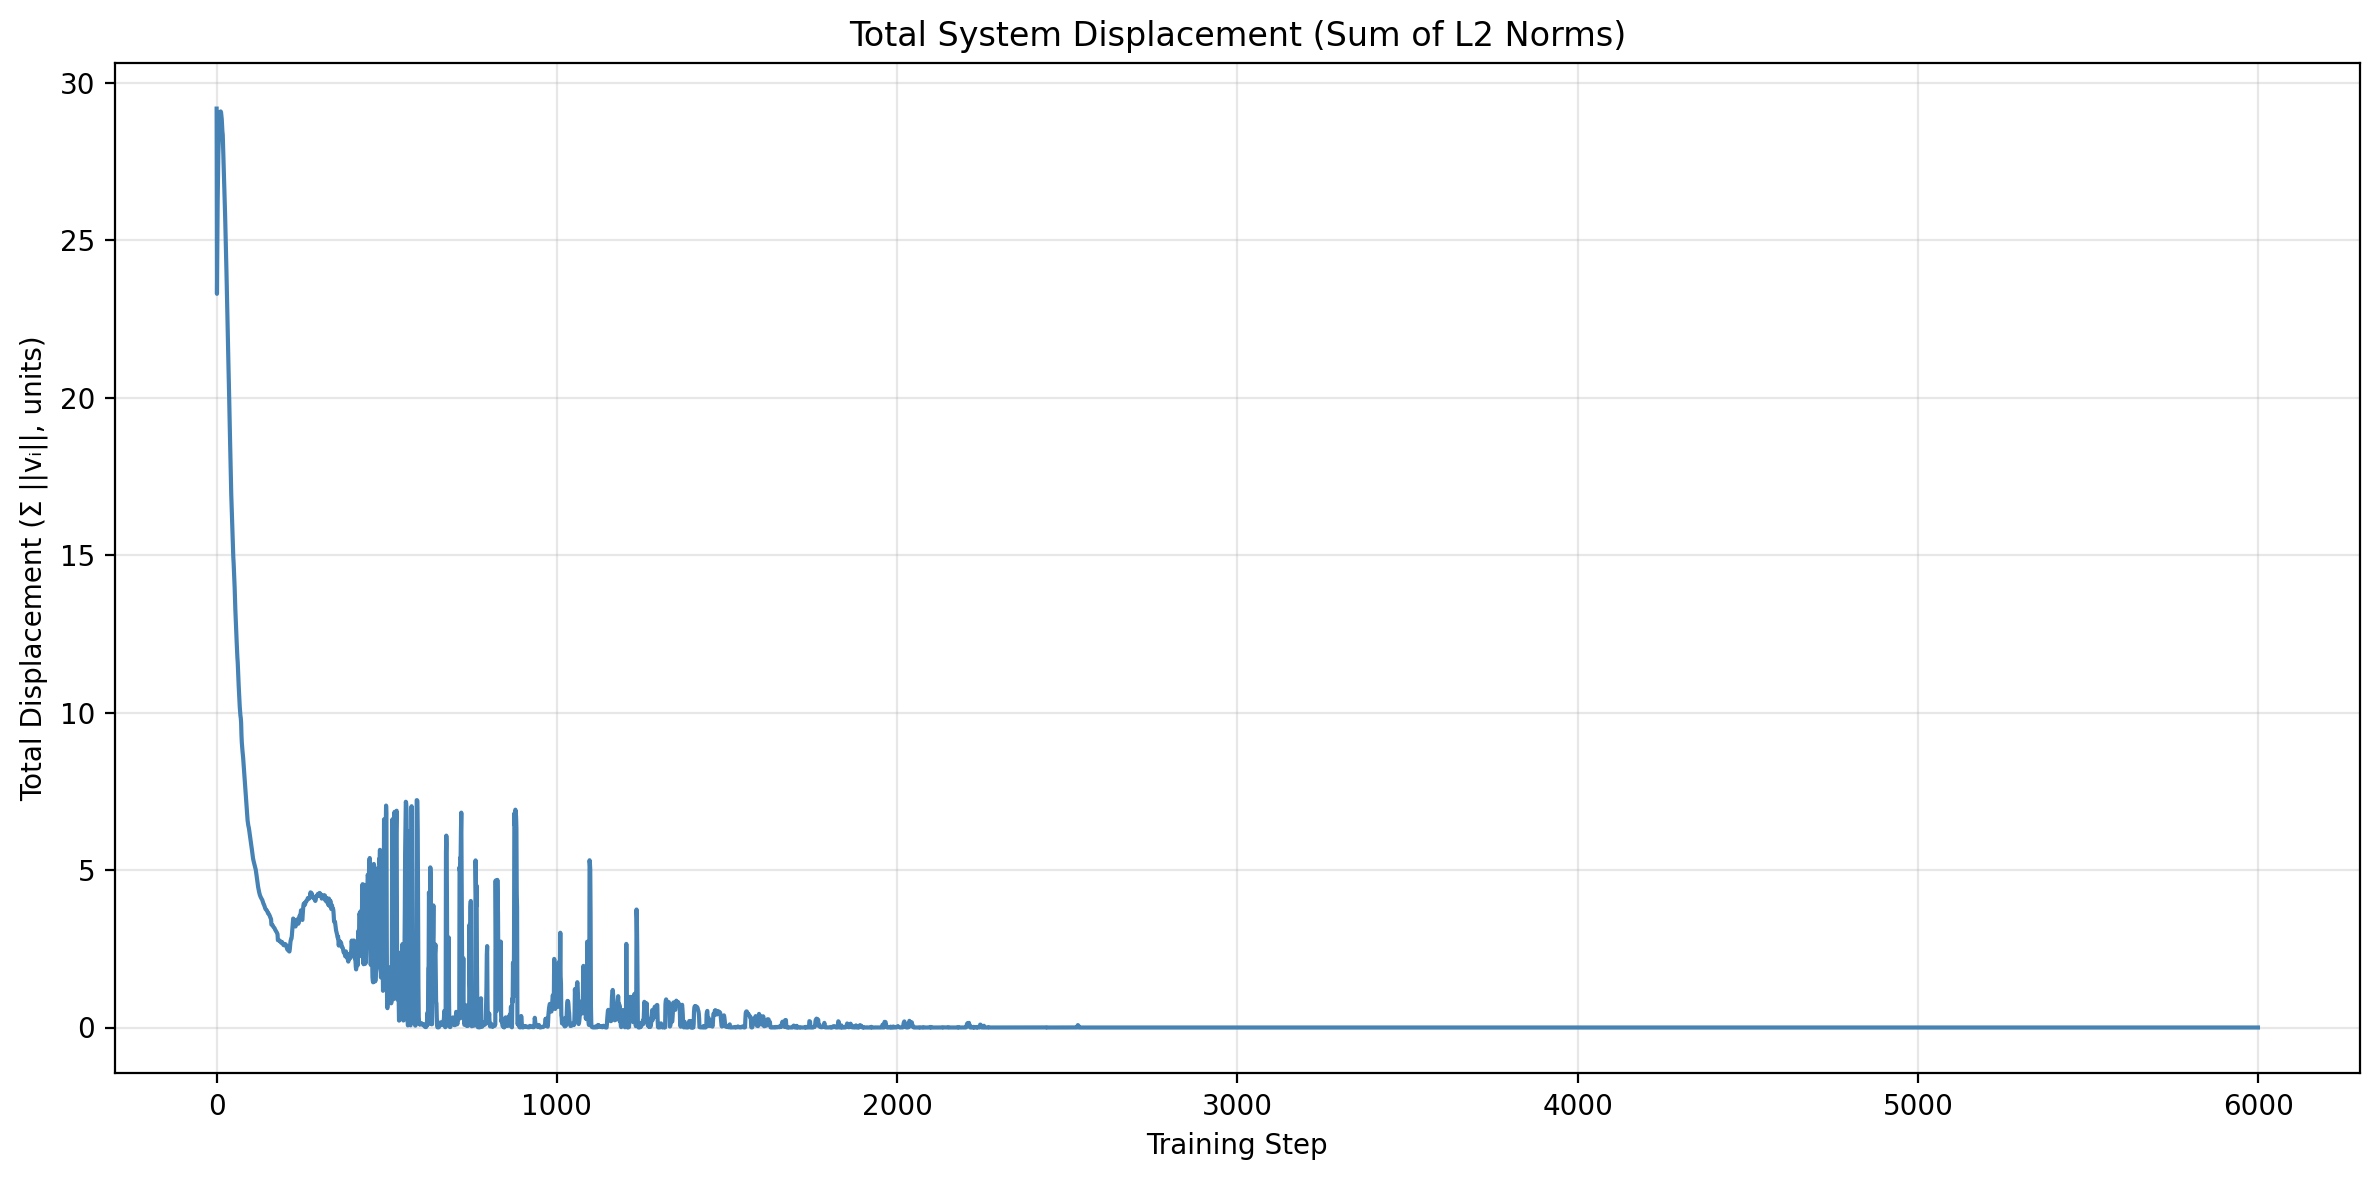


Interpretation: Total amount of motion happening across all dead tokens at each step.
Extensive quantity—scales with number of moving tokens AND their displacement magnitudes.


In [14]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(total_L2.numpy(), linewidth=1.5, color='steelblue')

ax.set_xlabel('Training Step')
ax.set_ylabel('Total Displacement (Σ ||vᵢ||, units)')
ax.set_title('Total System Displacement (Sum of L2 Norms)')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Total amount of motion happening across all dead tokens at each step.")
print("Extensive quantity—scales with number of moving tokens AND their displacement magnitudes.")

## Plot 2: Total Coordinate Change (L1 Sum)

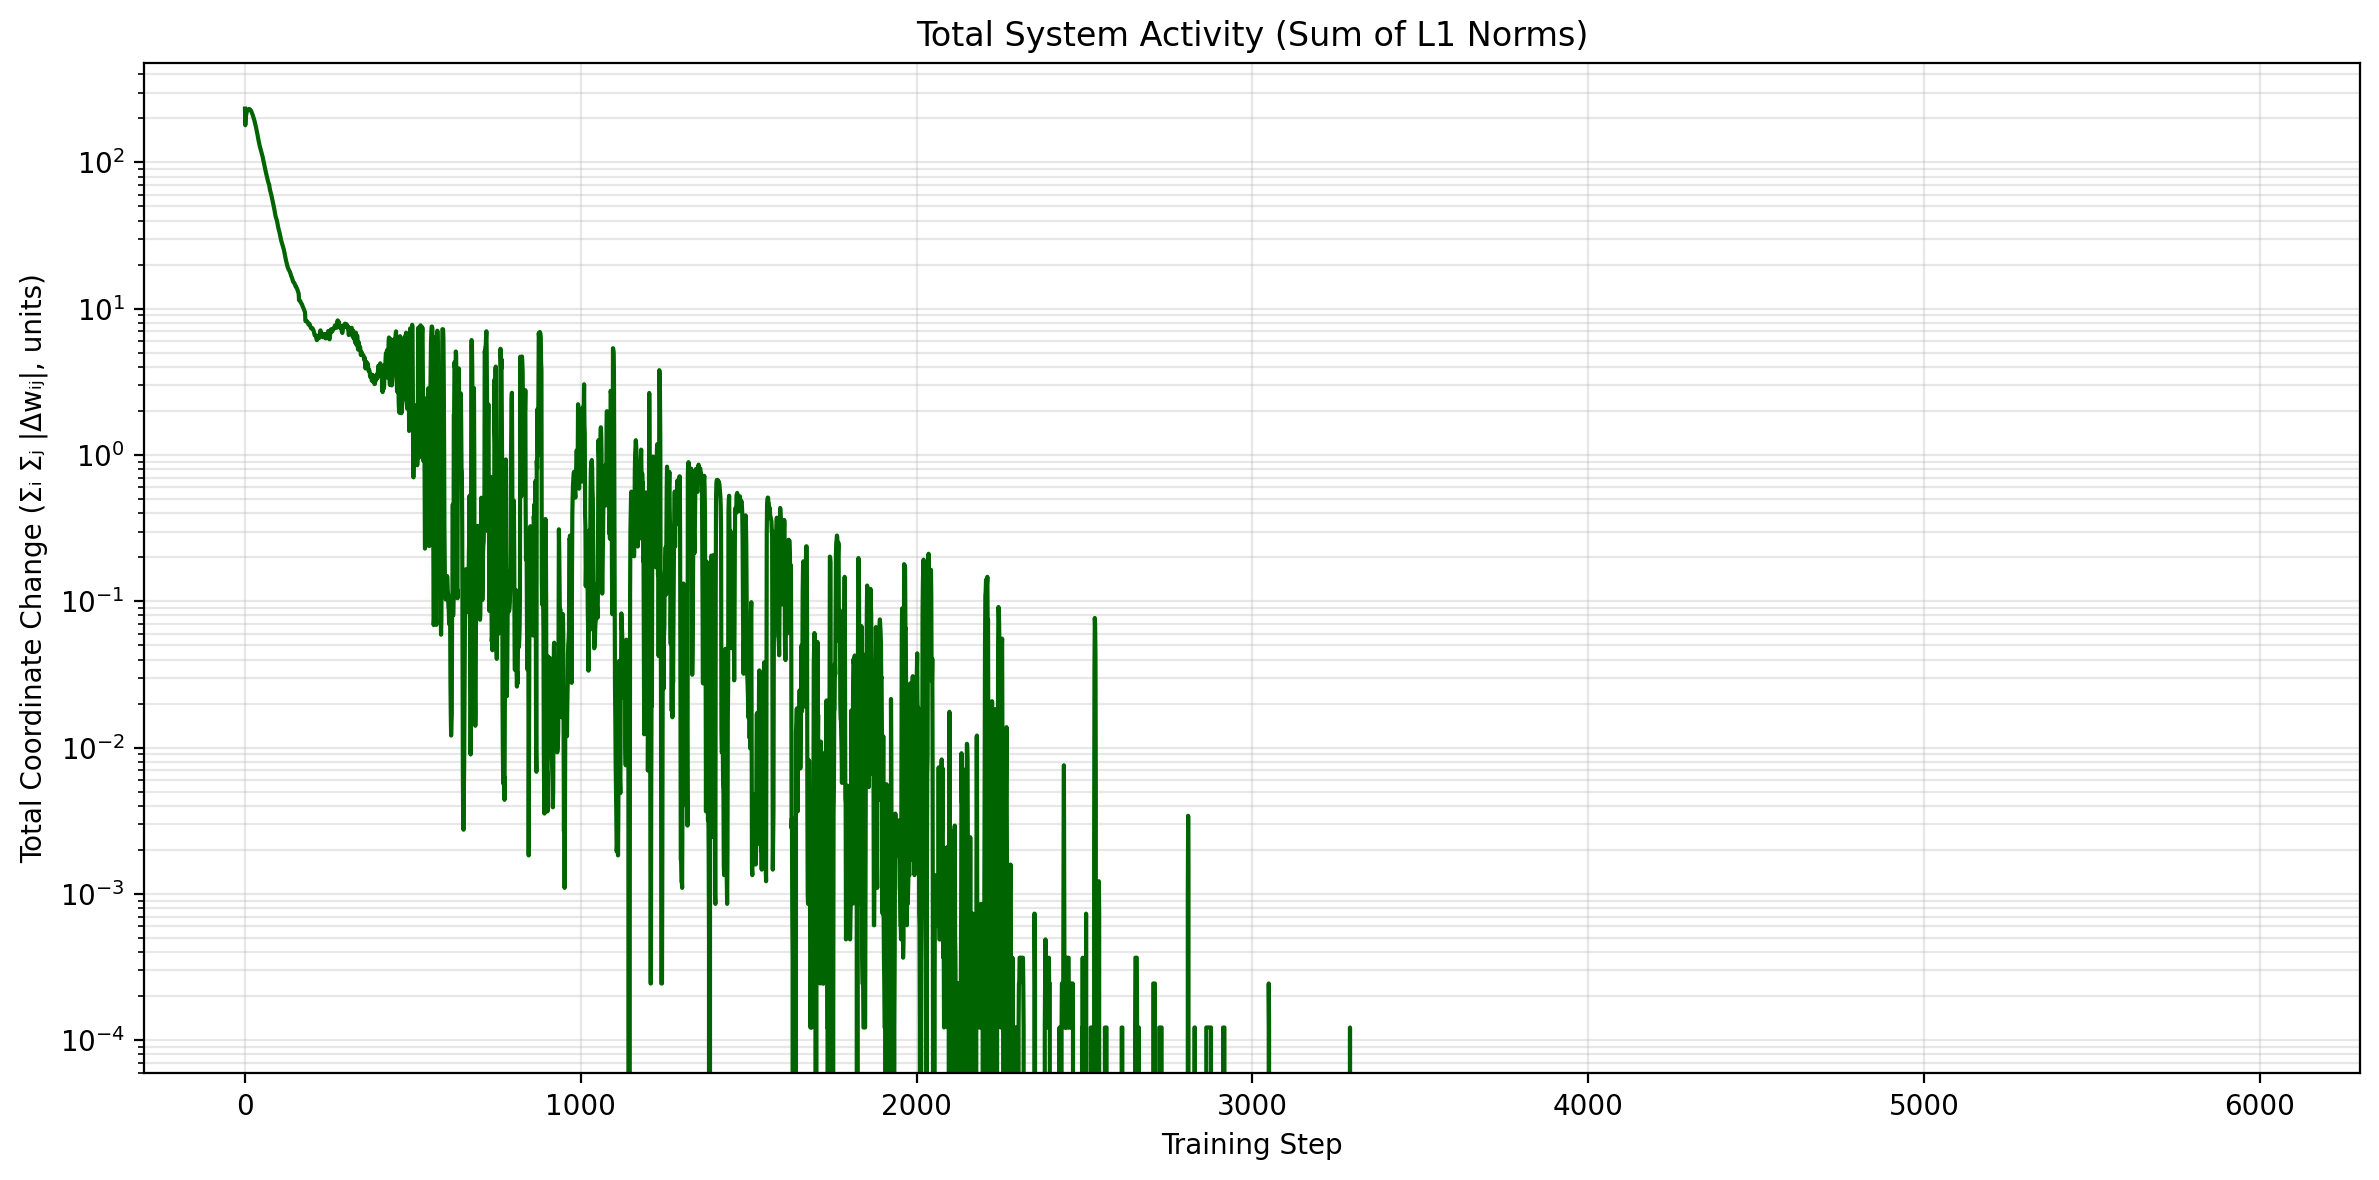


Interpretation: Sum of absolute value changes across all coordinates.
More robust to outliers than L2—treats all coordinate changes equally.


In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(total_L1.numpy(), linewidth=1.5, color='darkgreen')

ax.set_xlabel('Training Step')
ax.set_ylabel('Total Coordinate Change (Σᵢ Σⱼ |Δwᵢⱼ|, units)')
ax.set_title('Total System Activity (Sum of L1 Norms)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Sum of absolute value changes across all coordinates.")
print("More robust to outliers than L2—treats all coordinate changes equally.")

## Plot 3: "Kinetic Energy Analog"

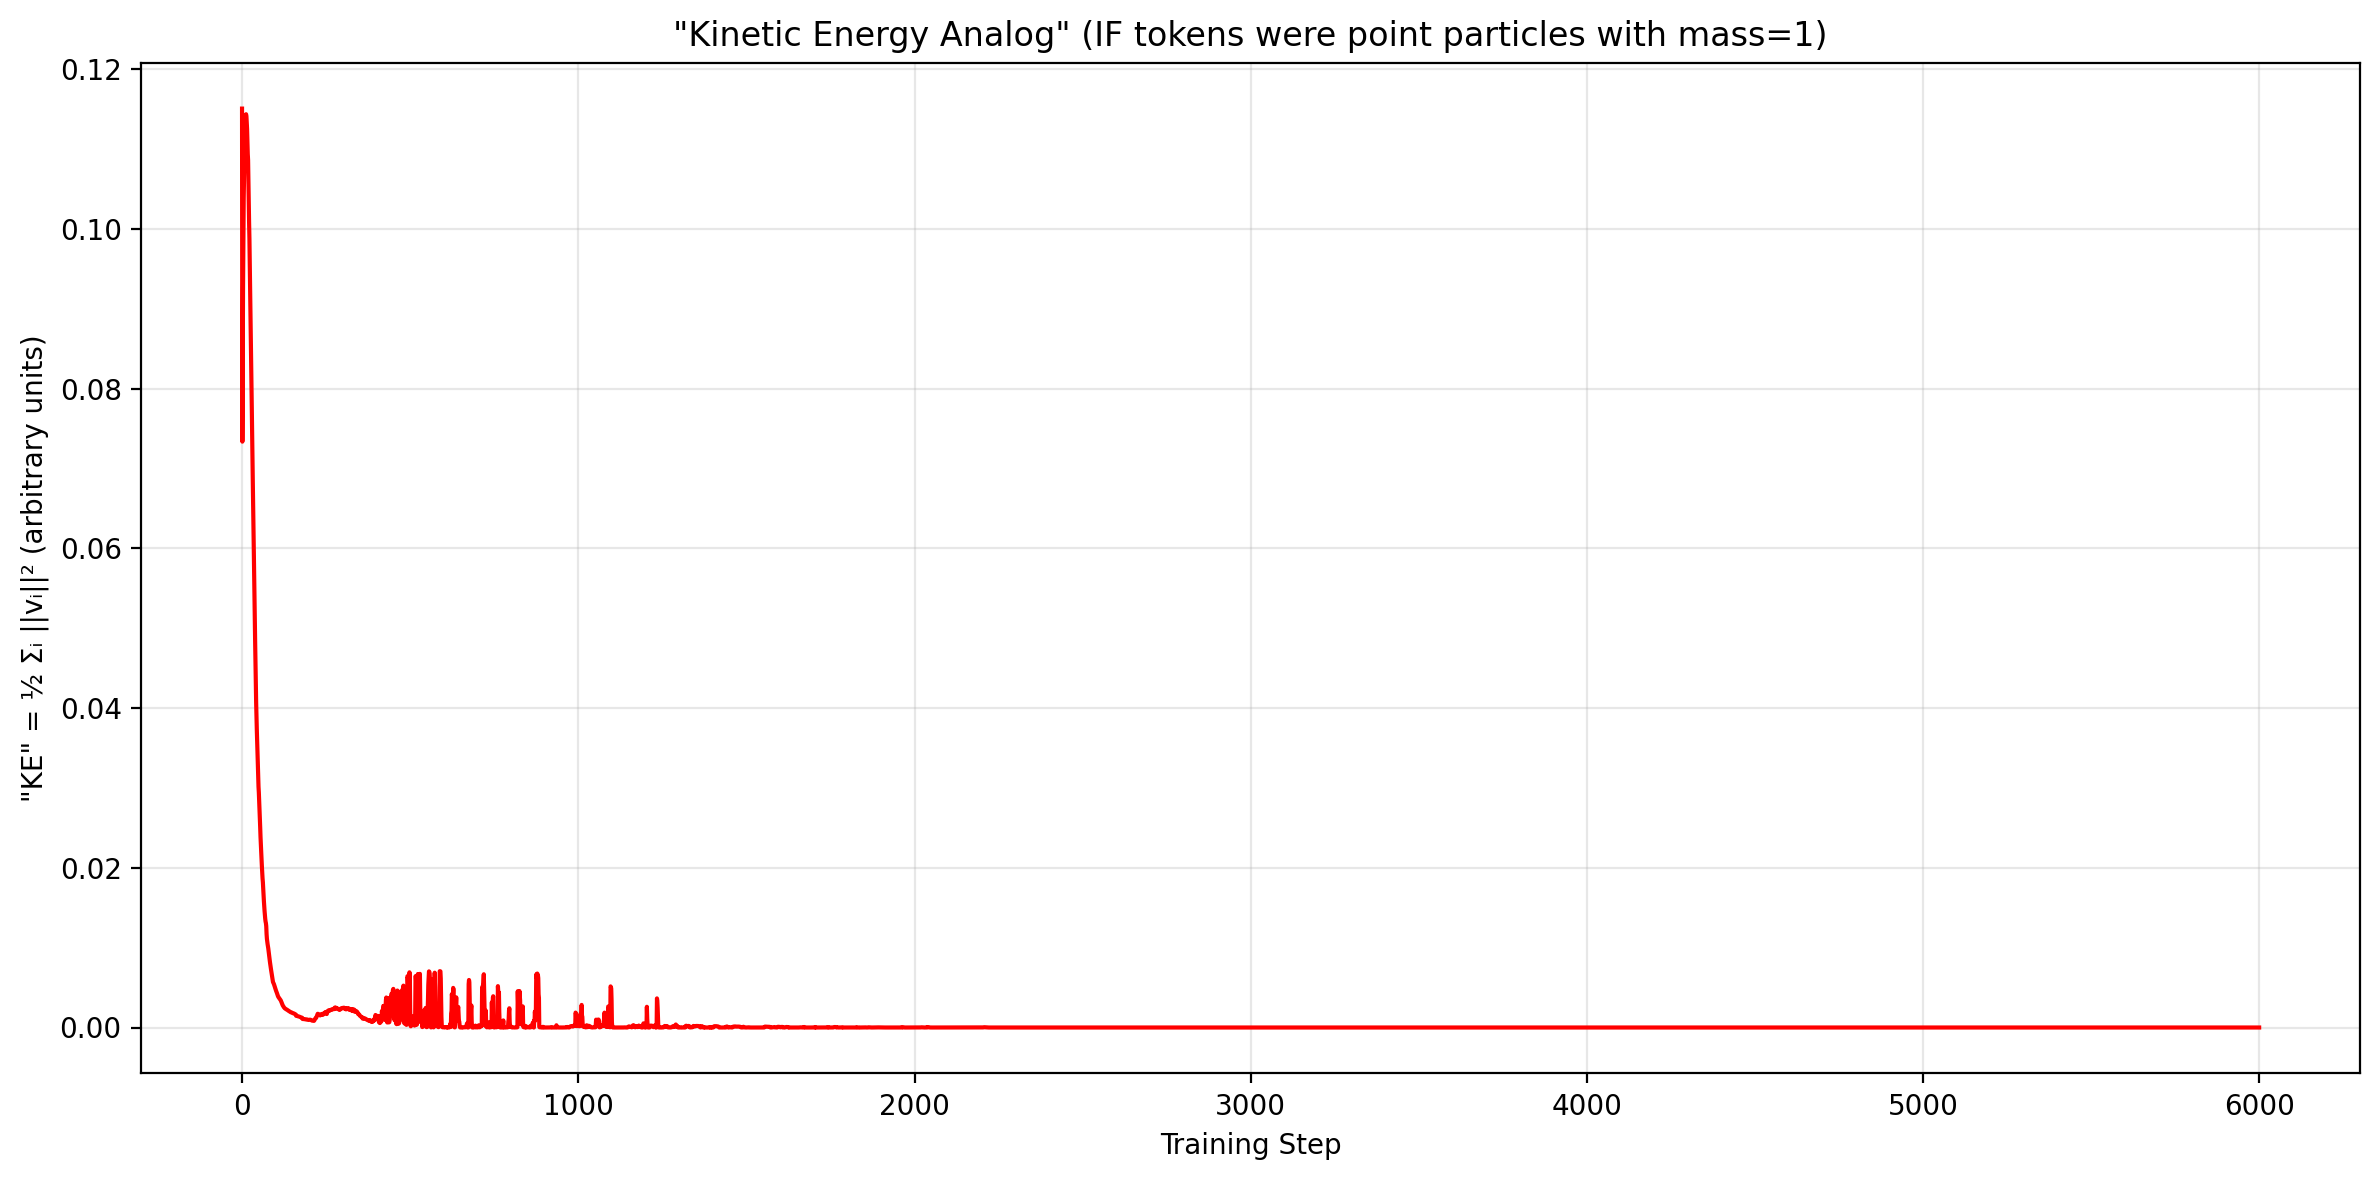


Interpretation: Quadratic in displacement—emphasizes large hops over small ones.
If this decays faster than total_L2, motion is becoming more uniform (democratic freeze).
If slower, a few hot tokens dominate even as most freeze (stratified freeze).


In [15]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(KE_analog.numpy(), linewidth=1.5, color='red')

ax.set_xlabel('Training Step')
ax.set_ylabel('"KE" = ½ Σᵢ ||vᵢ||² (arbitrary units)')
ax.set_title('"Kinetic Energy Analog" (IF tokens were point particles with mass=1)')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Quadratic in displacement—emphasizes large hops over small ones.")
print("If this decays faster than total_L2, motion is becoming more uniform (democratic freeze).")
print("If slower, a few hot tokens dominate even as most freeze (stratified freeze).")

## Plot 4: Max Displacement (Hottest Token)

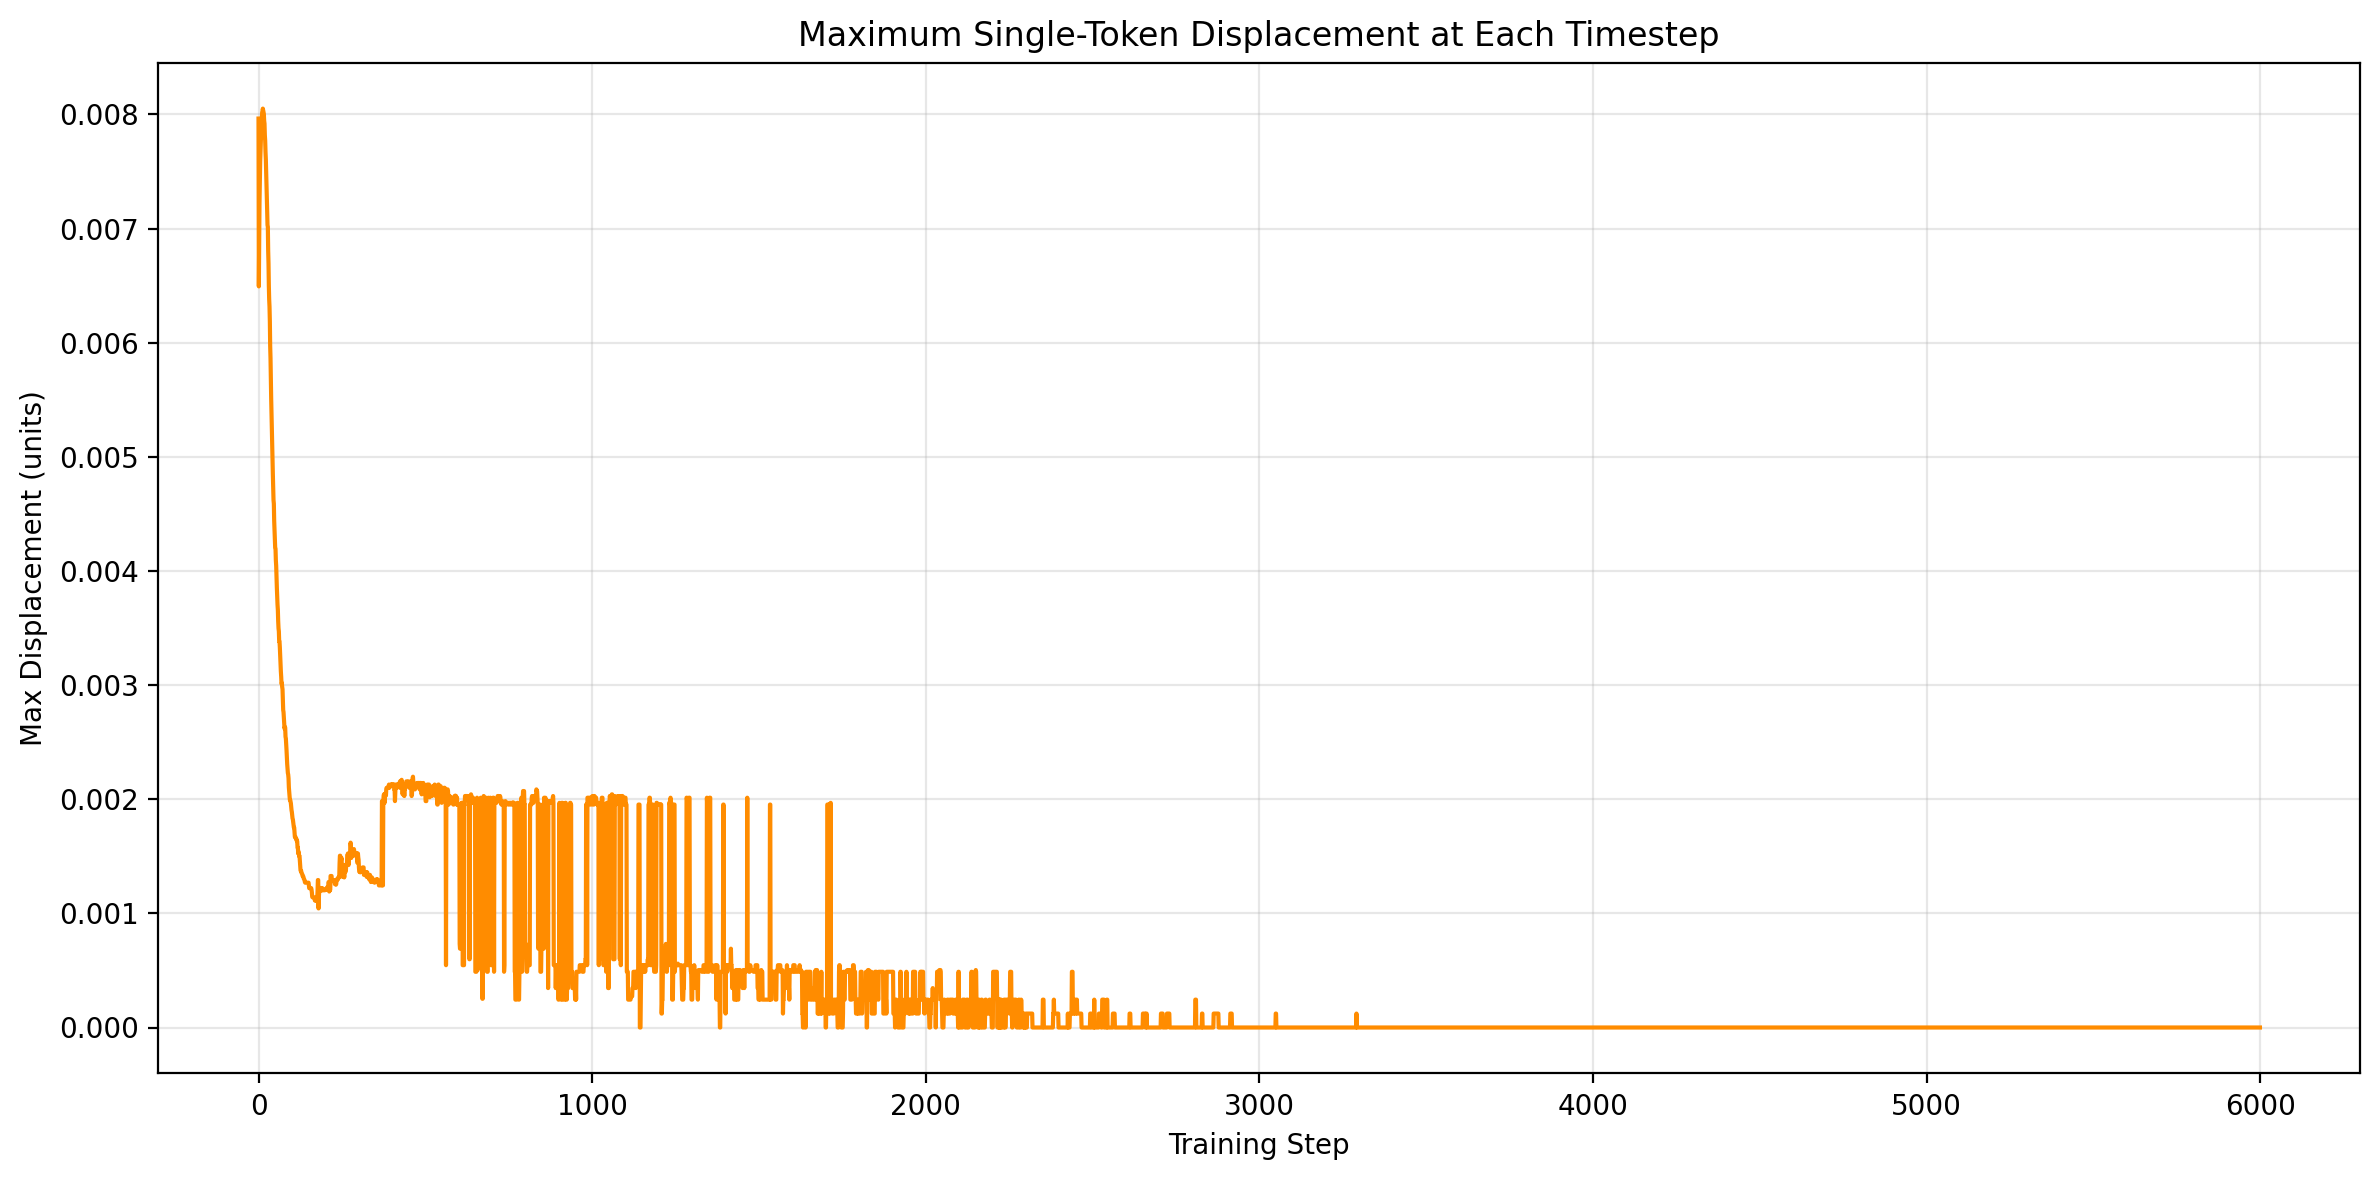


Interpretation: Tracks the 'hottest' token at each step.
Smooth decay → even the most active tokens cool gradually.
Plateaus with dips → some tokens stay hot while others freeze, then those freeze too.


In [16]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(max_displacement.numpy(), linewidth=1.5, color='darkorange')

ax.set_xlabel('Training Step')
ax.set_ylabel('Max Displacement (units)')
ax.set_title('Maximum Single-Token Displacement at Each Timestep')
ax.set_yscale('linear')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Tracks the 'hottest' token at each step.")
print("Smooth decay → even the most active tokens cool gradually.")
print("Plateaus with dips → some tokens stay hot while others freeze, then those freeze too.")

## Plot 5: Displacement Variance

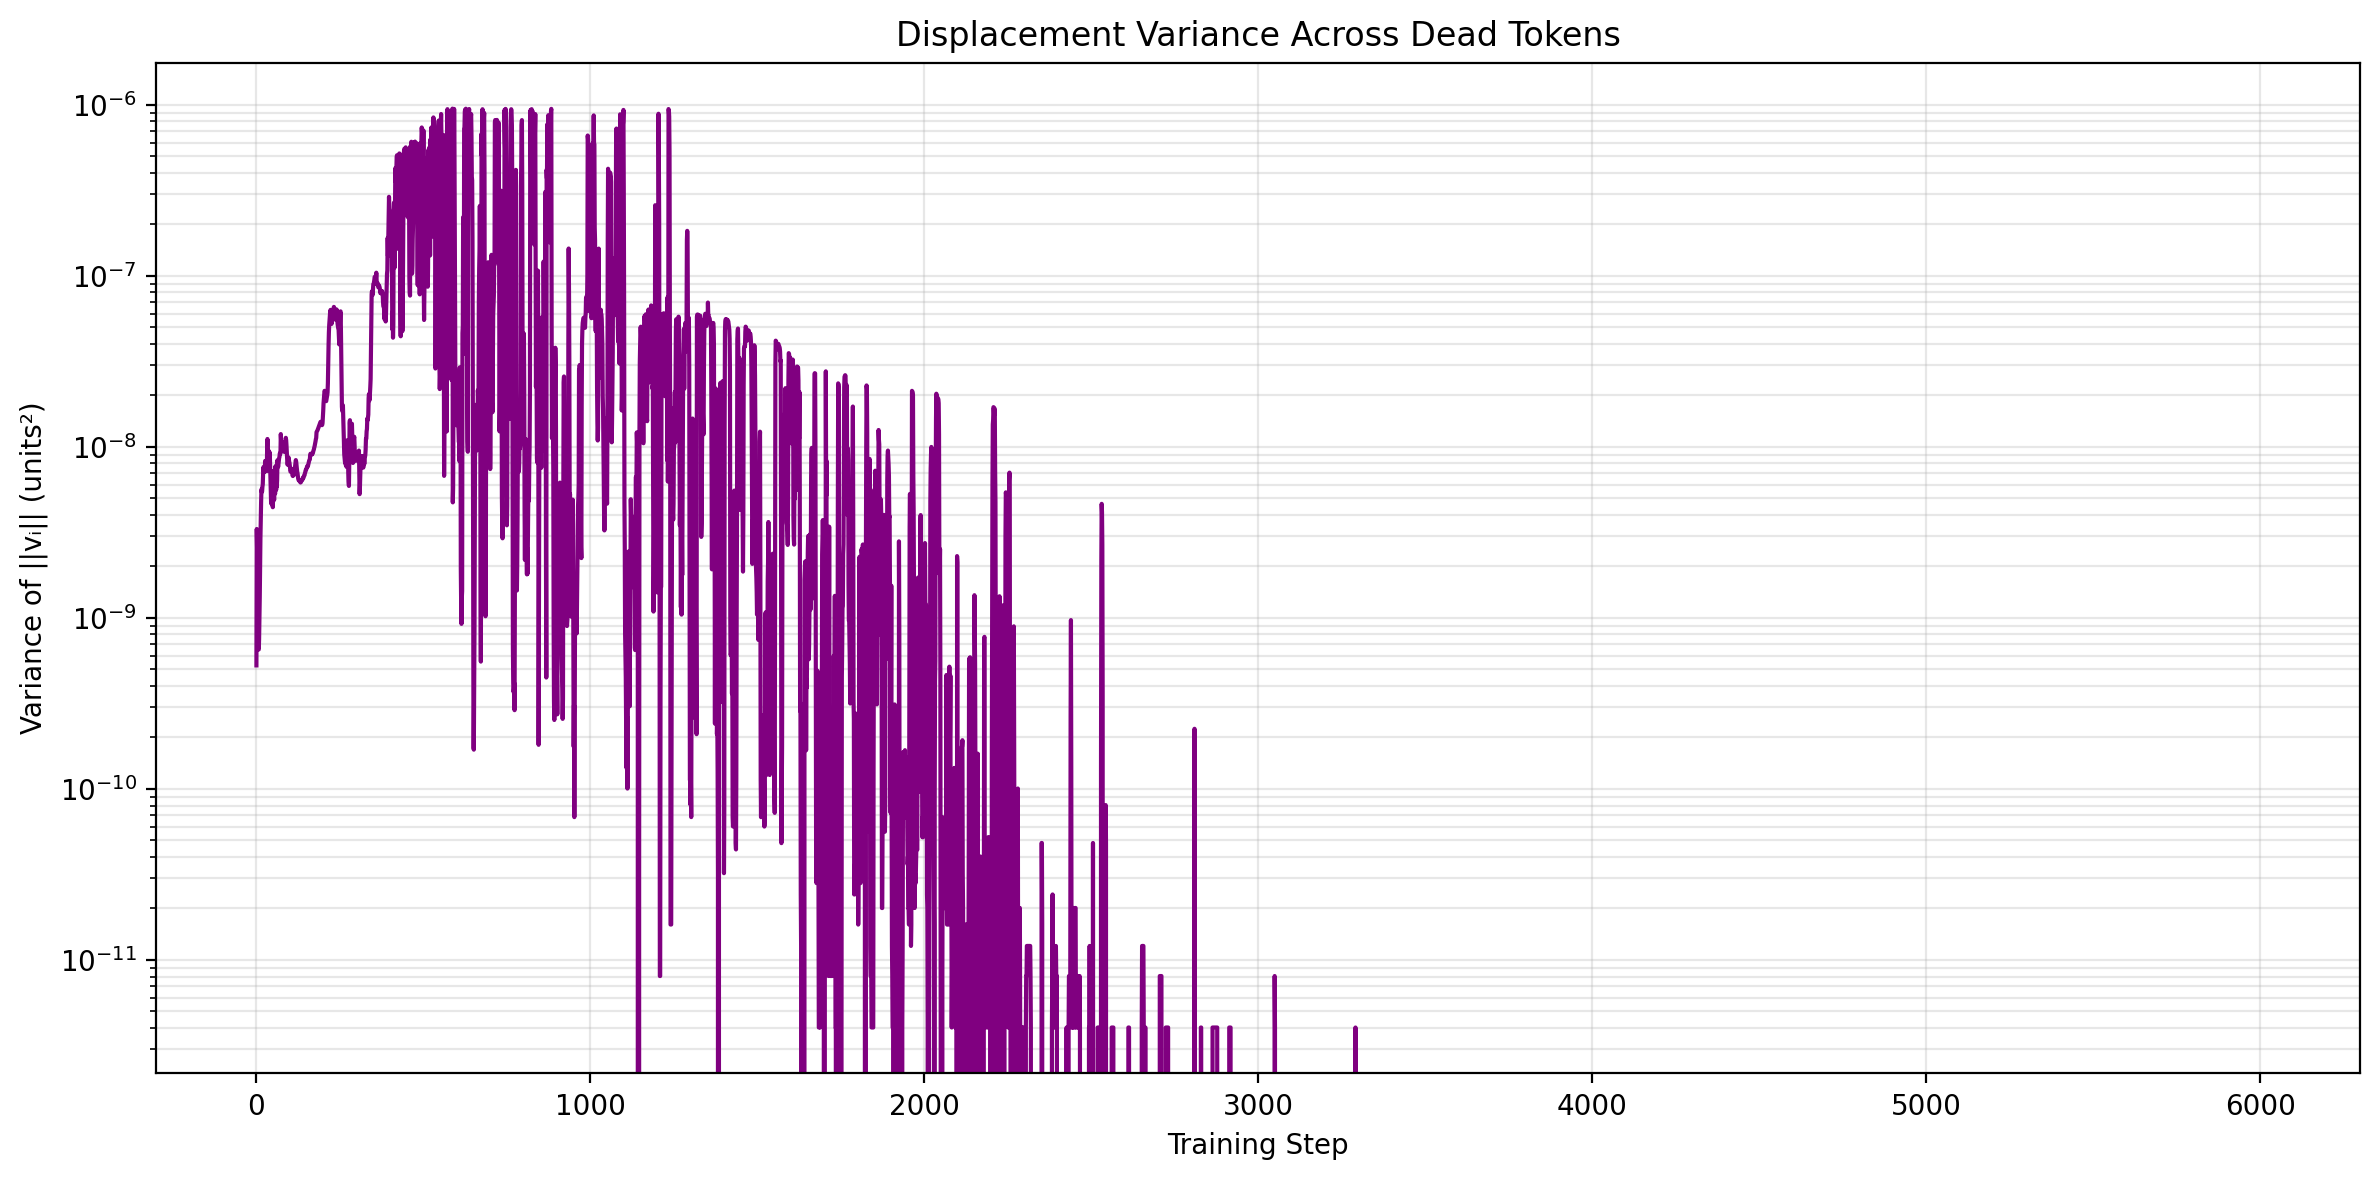


Interpretation: Spread of displacement magnitudes.
High variance → some tokens move a lot, others barely.
Low variance → tokens move uniformly (similar speeds).
Decay → as system freezes, spread narrows (all converging to zero).


In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(displacement_variance.numpy(), linewidth=1.5, color='purple')

ax.set_xlabel('Training Step')
ax.set_ylabel('Variance of ||vᵢ|| (units²)')
ax.set_title('Displacement Variance Across Dead Tokens')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation: Spread of displacement magnitudes.")
print("High variance → some tokens move a lot, others barely.")
print("Low variance → tokens move uniformly (similar speeds).")
print("Decay → as system freezes, spread narrows (all converging to zero).")

## Plot 6: Participation Ratio

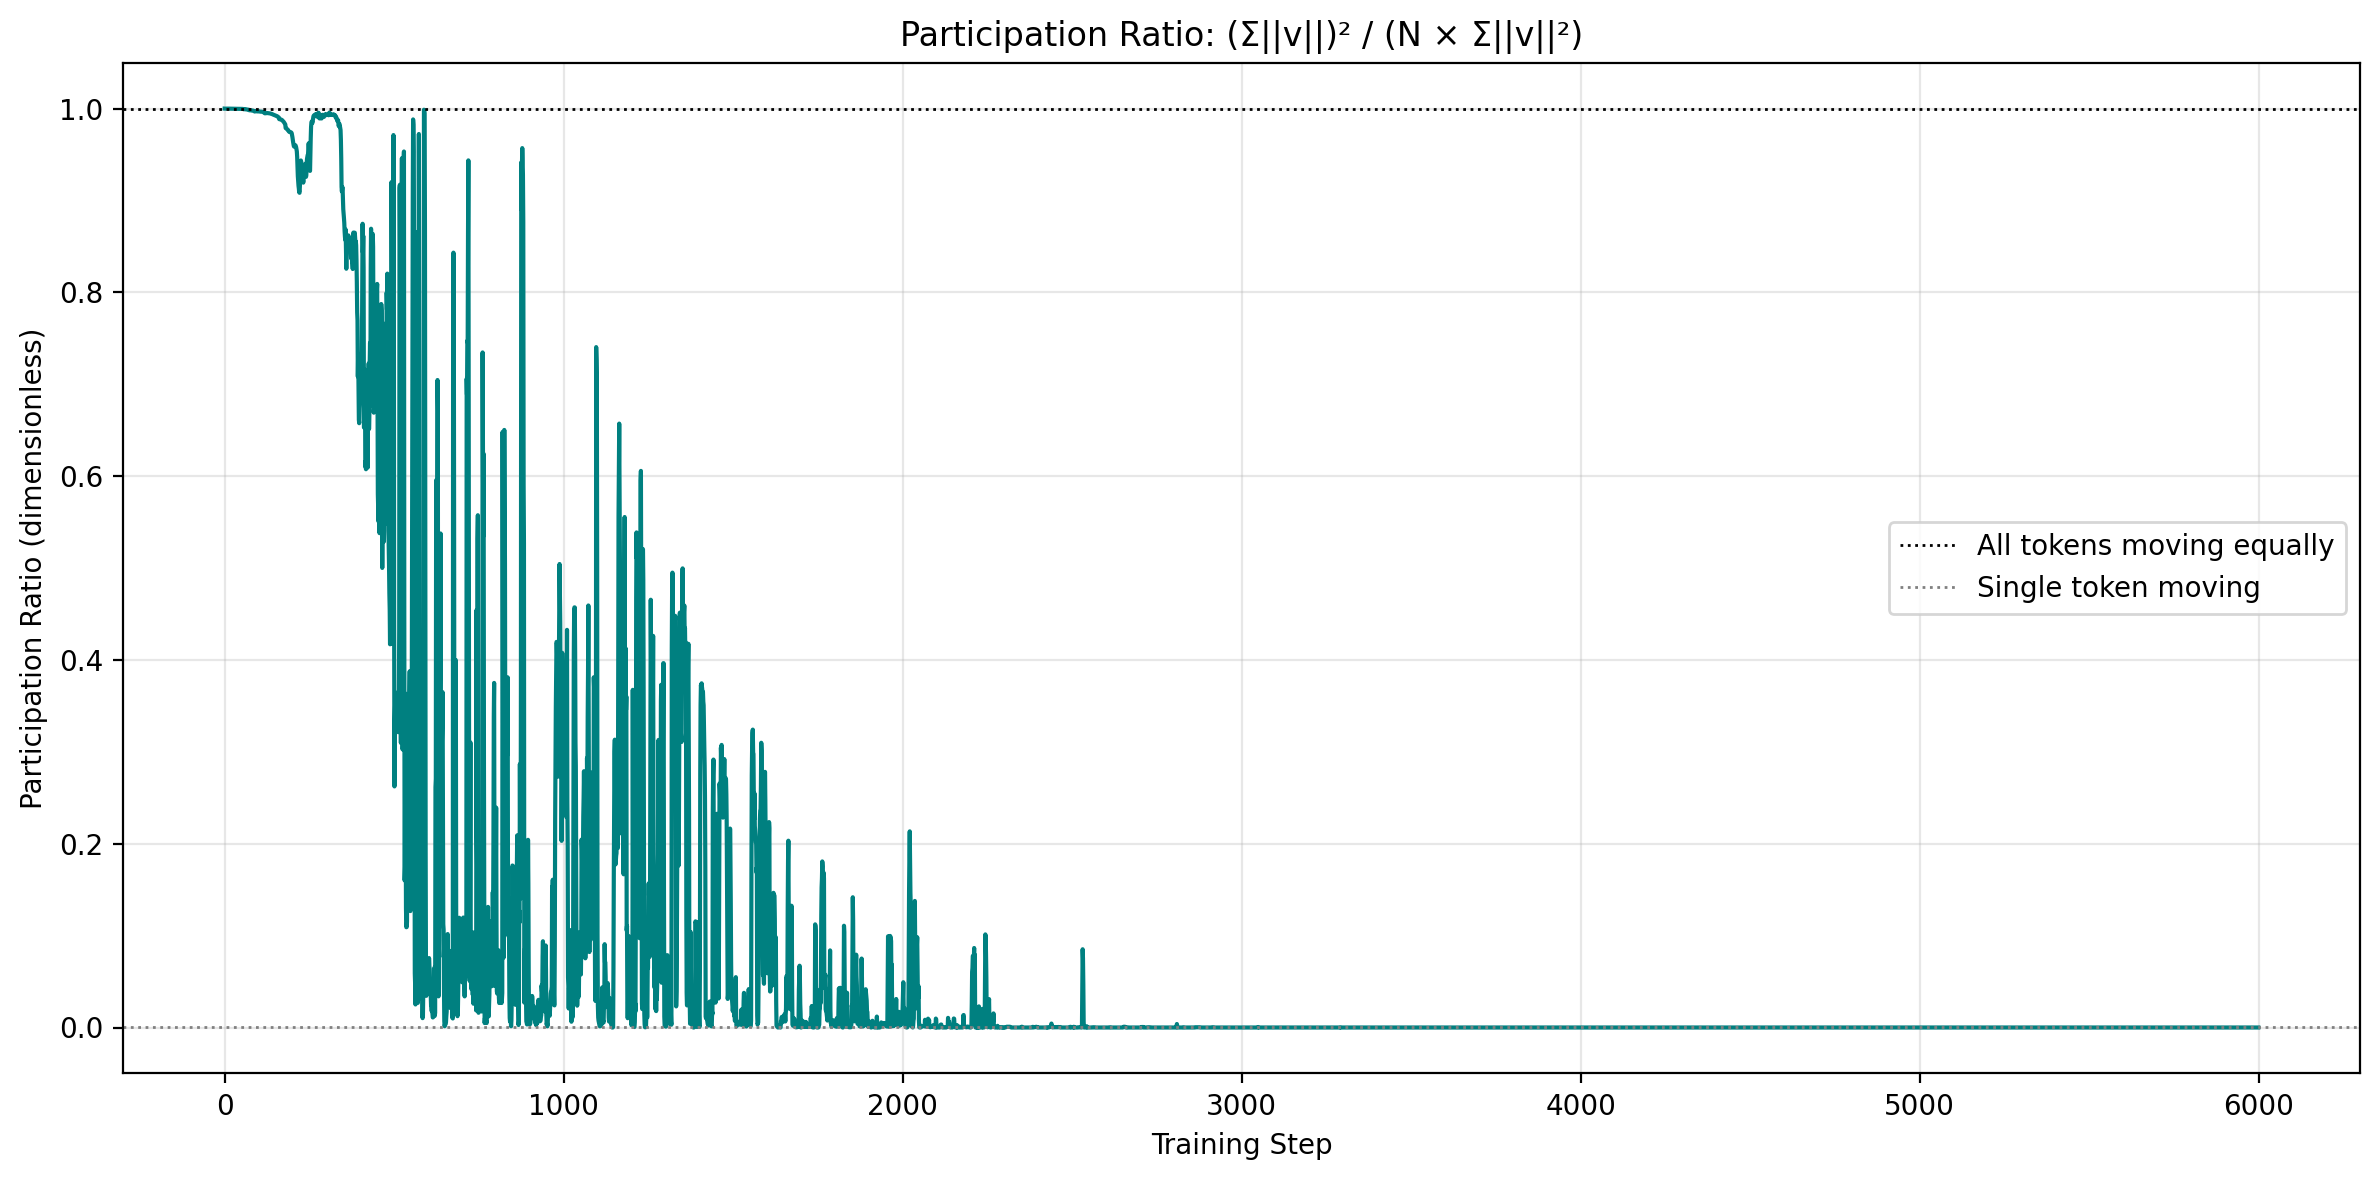


Interpretation: How 'democratic' is the motion?
  PR = 1.0:     All 3699 tokens moving equally
  PR = 2.70e-04: Only 1 token moving
  PR decreasing: Motion concentrating on fewer tokens (stratification)
  PR steady:     Uniform cooling (everyone slows together)


In [11]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(participation_ratio.numpy(), linewidth=1.5, color='teal')

ax.set_xlabel('Training Step')
ax.set_ylabel('Participation Ratio (dimensionless)')
ax.set_title('Participation Ratio: (Σ||v||)² / (N × Σ||v||²)')
ax.axhline(1.0, color='black', linestyle=':', linewidth=1, label='All tokens moving equally')
ax.axhline(1/n_dead, color='gray', linestyle=':', linewidth=1, label='Single token moving')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: How 'democratic' is the motion?")
print(f"  PR = 1.0:     All {n_dead} tokens moving equally")
print(f"  PR = {1/n_dead:.2e}: Only 1 token moving")
print("  PR decreasing: Motion concentrating on fewer tokens (stratification)")
print("  PR steady:     Uniform cooling (everyone slows together)")

## Comparison: Linear vs Quadratic Measures

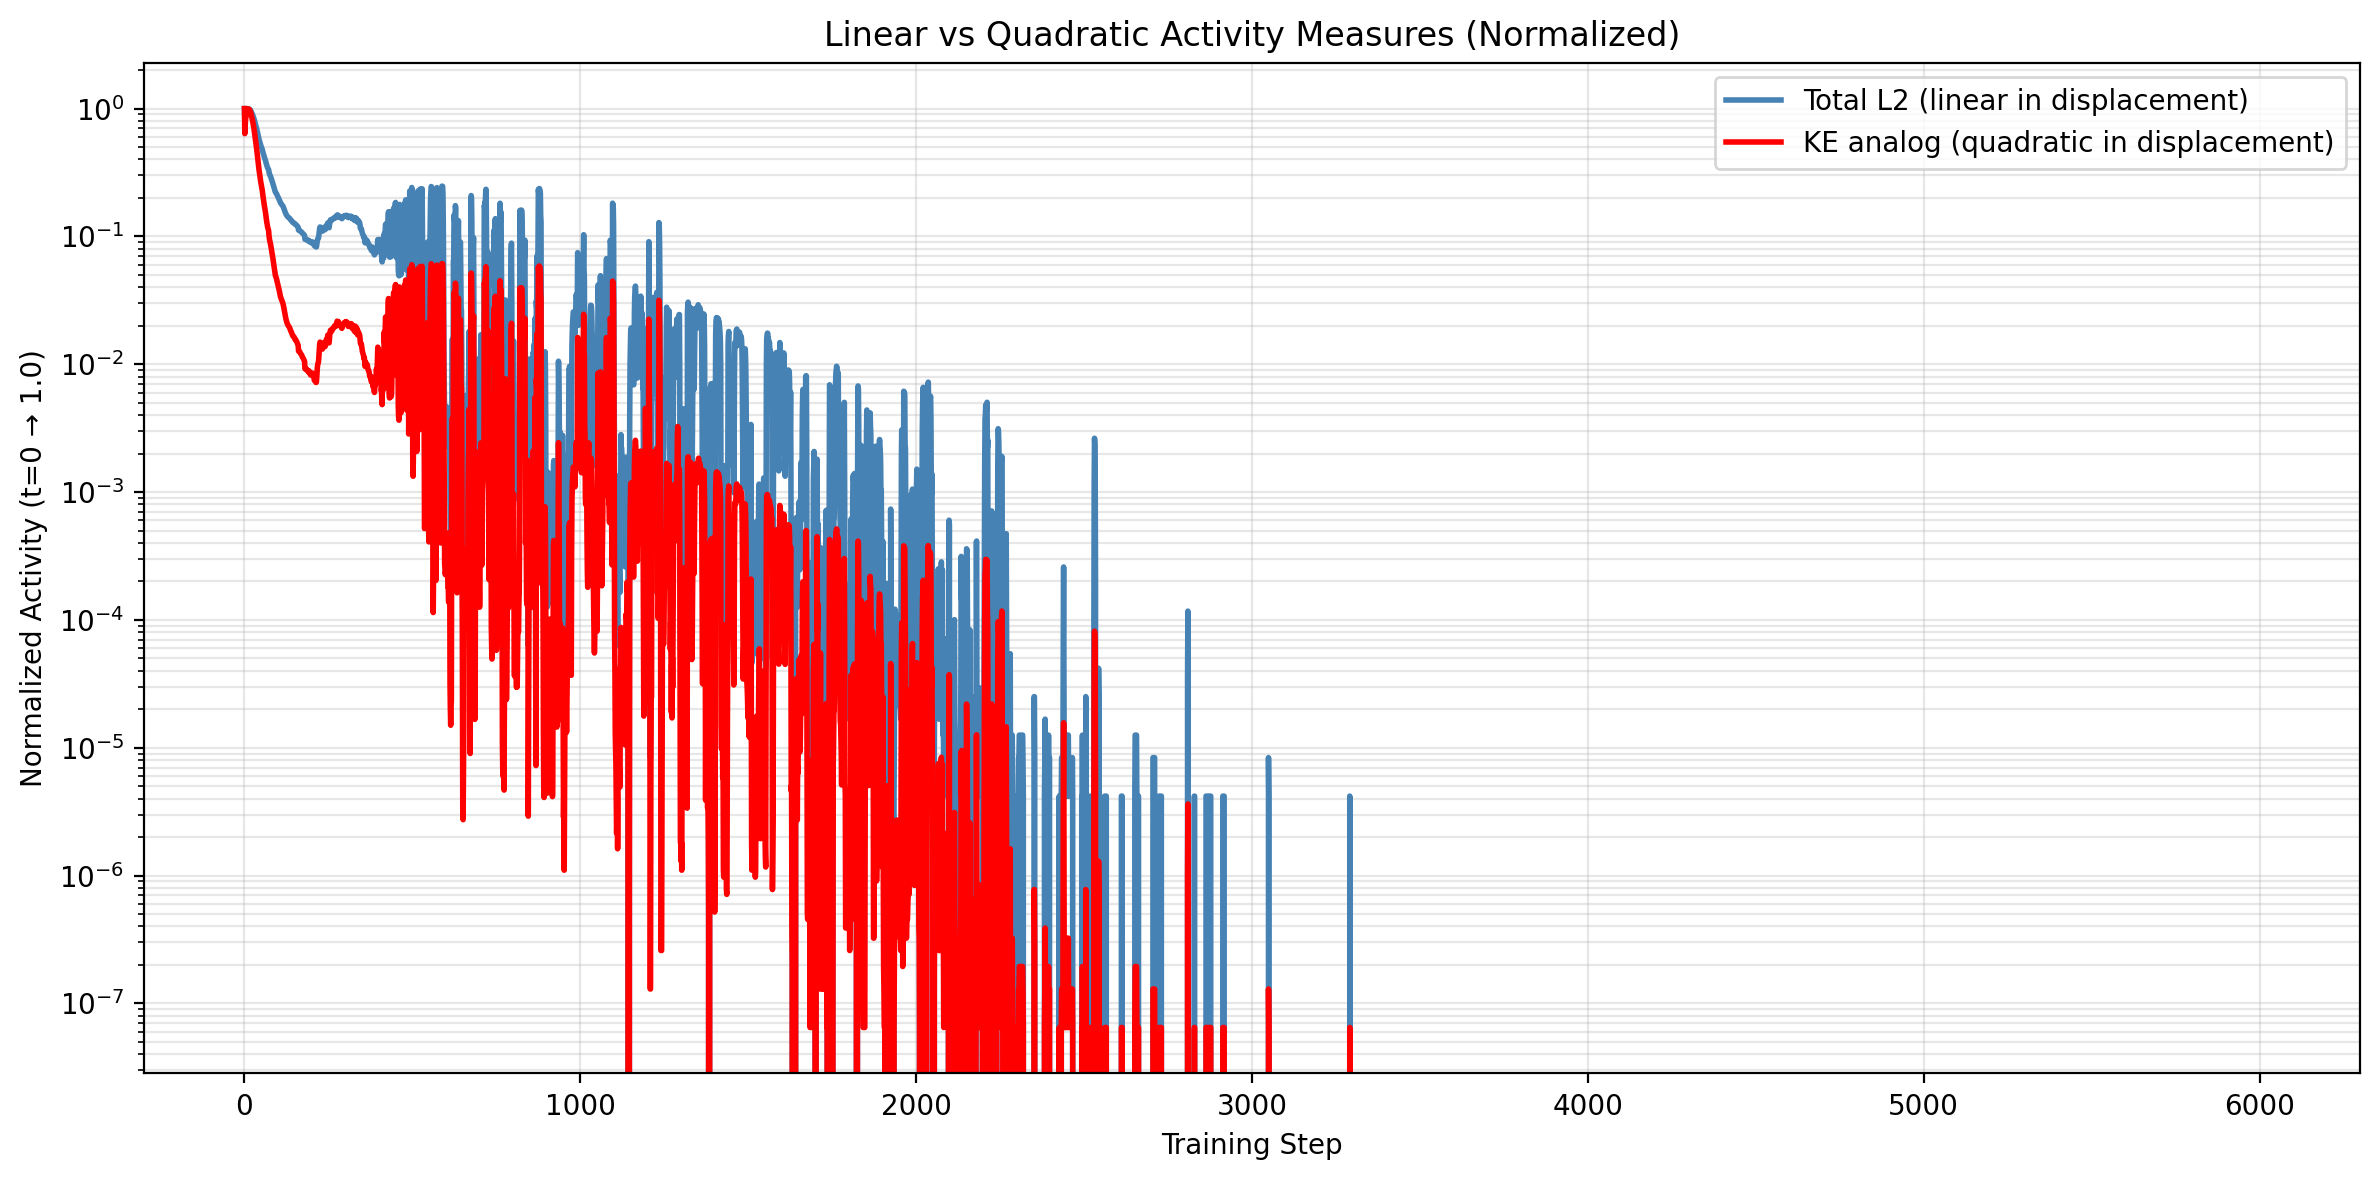


Interpretation:
  If curves overlap: Motion decays uniformly (no outliers dominating).
  If KE decays faster: Large hops disappear first → democratic freeze.
  If KE decays slower: Big hops persist → stratified freeze (hot tokens linger).


In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Normalize to [0, 1] for comparison
total_L2_norm = total_L2 / total_L2[0] if total_L2[0] > 0 else total_L2
KE_norm = KE_analog / KE_analog[0] if KE_analog[0] > 0 else KE_analog

ax.plot(total_L2_norm.numpy(), linewidth=2, color='steelblue', label='Total L2 (linear in displacement)')
ax.plot(KE_norm.numpy(), linewidth=2, color='red', label='KE analog (quadratic in displacement)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Normalized Activity (t=0 → 1.0)')
ax.set_title('Linear vs Quadratic Activity Measures (Normalized)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  If curves overlap: Motion decays uniformly (no outliers dominating).")
print("  If KE decays faster: Large hops disappear first → democratic freeze.")
print("  If KE decays slower: Big hops persist → stratified freeze (hot tokens linger).")

## Summary Statistics

In [13]:
print("\n" + "="*80)
print("SYSTEM-WIDE MOTION SUMMARY")
print("="*80 + "\n")

print(f"Dead tokens: {n_dead}\n")

# Initial vs final
print("Activity at key timesteps:\n")
checkpoints = [0, 100, 500, 1000, 2000, 3000, 3291, 3292, 4000, 5000, 5999]
print(f"{'t':>6s} {'Total L2':>12s} {'Total L1':>12s} {'KE analog':>12s} {'Max disp':>12s} {'N moving':>10s} {'Part. ratio':>12s}")
print("-" * 80)
for t in checkpoints:
    if t < len(total_L2):
        print(f"{t:6d} {total_L2[t].item():12.4e} {total_L1[t].item():12.4e} {KE_analog[t].item():12.4e} {max_displacement[t].item():12.4e} {n_moving[t].item():10.0f} {participation_ratio[t].item():12.4f}")

print("\n" + "="*80)

# Decay rates
if total_L2[0] > 0:
    decay_L2 = total_L2[-1] / total_L2[0]
    decay_KE = KE_analog[-1] / KE_analog[0] if KE_analog[0] > 0 else 0
    
    print("\nDecay factors (final / initial):\n")
    print(f"  Total L2:   {decay_L2:.2e}")
    print(f"  KE analog:  {decay_KE:.2e}")
    print(f"  Ratio (KE/L2 decay): {(decay_KE/decay_L2 if decay_L2 > 0 else 0):.2f}")
    
    if decay_KE / decay_L2 < 0.9:
        print("\n  → KE decays faster: Large hops disappear preferentially (democratic freeze)")
    elif decay_KE / decay_L2 > 1.1:
        print("\n  → KE decays slower: Large hops persist (stratified freeze)")
    else:
        print("\n  → KE and L2 decay similarly: Uniform cooling")

print("\n" + "="*80)
print("✓ System-wide motion analysis complete.")
print("="*80)
print("\nReminder: These are *descriptive statistics*, not thermodynamic claims.")
print("We're just asking: IF tokens were particles, what would we see?")


SYSTEM-WIDE MOTION SUMMARY

Dead tokens: 3699

Activity at key timesteps:

     t     Total L2     Total L1    KE analog     Max disp   N moving  Part. ratio
--------------------------------------------------------------------------------
     0   2.9173e+01   2.3330e+02   1.1504e-01   7.9634e-03       3699       1.0000
   100   5.9092e+00   3.5146e+01   4.7344e-03   1.8872e-03       3699       0.9970
   500   2.8614e+00   3.0040e+00   2.4178e-03   2.0463e-03       2403       0.4578
  1000   8.8041e-01   9.1528e-01   3.9053e-04   2.0132e-03       1461       0.2683
  2000   1.9165e-02   1.9165e-02   2.2873e-06   2.4414e-04         82       0.0217
  3000   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00          0       0.0000
  3291   1.2207e-04   1.2207e-04   7.4506e-09   1.2207e-04          1       0.0003
  3292   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00          0       0.0000
  4000   0.0000e+00   0.0000e+00   0.0000e+00   0.0000e+00          0       0.0000
  5000   0.00